<a href="https://colab.research.google.com/github/axb9088/Customer-Segmentation-and-Marketing-Optimization/blob/main/Final_Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install category_encoders shap lime interpret pdpbox PyALE aif360 folktables alibi joblib dice-ml


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 58.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of salib to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
import shap
import lime
import lime.lime_tabular
import joblib
import dice_ml as dice


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.blackbox import PartialDependence
from interpret.perf import ROC
from sklearn.inspection import PartialDependenceDisplay
from PyALE import ale
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from alibi.explainers import AnchorTabular
import dice_ml
from dice_ml.utils import helpers

In [ ]:
df_ = pd.read_csv("/content/drive/MyDrive/SEM 4/Training Data.csv")
df = df_.copy()
print("Shape of the dataset:" ,df.shape)
print("Columns in the Dataset:",df.columns)

Shape of the dataset: (252000, 13)
Columns in the Dataset: Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.sample(10)

Id   Income  Age  Experience Married/Single House_Ownership  \
133488  133489  2871831   38          14         single          rented   
76774    76775  1117607   53          13        married          rented   
143309  143310  9627469   48          17        married          rented   
249222  249223  3328698   60           1         single          rented   
137048  137049  3017006   32           4         single          rented   
55437    55438  8845611   37          14         single          rented   
121578  121579  4324181   21          11         single          rented   
194649  194650  6272411   69           2        married          rented   
251747  251748  6511206   67          16         single          rented   
76816    76817  7223191   44           9         single          rented   

       Car_Ownership              Profession                   CITY  \
133488            no             Firefighter            Hajipur[31]   
76774            yes     Mechanical_engineer        Chandigarh_city   
143309            no                 Drafter                  Alwar   
249222            no                  Lawyer                 Nagaon   
137048           yes       Financial_Analyst  Sangli-Miraj_&_Kupwad   
55437             no               Physician                  Avadi   
121578            no            Army_officer         Ramagundam[27]   
194649            no                 Aviator               Bhatpara   
251747            no               Economist               Bareilly   
76816             no  Air_traffic_controller                Asansol   

                STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
133488          Bihar               11                 13          0  
76774      Chandigarh                6                 10          0  
143309      Rajasthan                6                 14          0  
249222          Assam                1                 11          0  
137048    Maharashtra                4                 11          0  
55437      Tamil_Nadu               10                 13          0  
121578      Telangana               11                 11          0  
194649    West_Bengal                2                 10          0  
251747  Uttar_Pradesh                8                 11          0  
76816     West_Bengal                9                 13          0

In [ ]:
def clean_and_encode_location(df):
    df['CITY_'] = df['CITY'].replace(r'[\d+\[\]]','',regex=True)
    df['STATE_'] = df['STATE'].str.replace('_',' ')
    df['Location'] = df['CITY_']+df['STATE_']
    df['Location'] = df['Location'].replace('\s+','',regex=True)
    df['Location'] = df['Location'].replace('[,_-]+','',regex=True)
    df['Location'] = df['Location'].replace(r'[\d+\[\]]','',regex=True)
    df['Location'] = df['Location'].replace(r'[^a-zA-Z]','',regex=True)
    df['Location'] = df['Location'].str.lower()
    return df

def enocoding_binary_columns(df):
    df['enc_Married_Single'] = df['Married/Single'].map({'single' : 1, 'married':0})
    df['enc_car_ownership'] = df['Car_Ownership'].map({'no':0, 'yes':1})
    return df

def BNRY_ENCDR(df,col):
    encoder = ce.BinaryEncoder(cols=[col],return_df=True)
    df = encoder.fit_transform(df)
    return df

def OHE_ENCDR(df,col):
    encoder=ce.OneHotEncoder(cols=col,handle_unknown='return_nan',return_df=True,use_cat_names=True)
    df = encoder.fit_transform(df)
    return df

def LBL_ENCDR(df,col):
    le = LabelEncoder()
    enc_col = 'enc_' + col
    df[enc_col] = le.fit_transform(df[col])
    return df


In [ ]:
df_enc = clean_and_encode_location(df)
df_enc = OHE_ENCDR(df_enc,'Married/Single')
df_enc = OHE_ENCDR(df_enc,'Car_Ownership')

df_enc = BNRY_ENCDR(df_enc,'House_Ownership')

df_enc = LBL_ENCDR(df_enc,'Profession')
df_enc = LBL_ENCDR(df_enc,'Location')

df_enc.drop(['Id','CITY', 'STATE'],axis=1,inplace=True)

print("Shape after encoding and dropping:", df_enc.shape)

df_enc.head()

Shape after encoding and dropping: (252000, 18)


Income  Age  Experience  Married/Single_single  Married/Single_married  \
0  1303834   23           3                    1.0                     0.0   
1  7574516   40          10                    1.0                     0.0   
2  3991815   66           4                    0.0                     1.0   
3  6256451   41           2                    1.0                     0.0   
4  5768871   47          11                    1.0                     0.0   

   House_Ownership_0  House_Ownership_1  Car_Ownership_no  Car_Ownership_yes  \
0                  0                  1               1.0                0.0   
1                  0                  1               1.0                0.0   
2                  0                  1               1.0                0.0   
3                  0                  1               0.0                1.0   
4                  0                  1               1.0                0.0   

            Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  \
0  Mechanical_engineer                3                 13          0   
1   Software_Developer                9                 13          0   
2     Technical_writer                4                 10          0   
3   Software_Developer                2                 12          1   
4        Civil_servant                3                 14          1   

             CITY_          STATE_                  Location  enc_Profession  \
0             Rewa  Madhya Pradesh         rewamadhyapradesh              33   
1         Parbhani     Maharashtra       parbhanimaharashtra              43   
2        Alappuzha          Kerala           alappuzhakerala              47   
3      Bhubaneswar          Odisha         bhubaneswarodisha              43   
4  Tiruchirappalli      Tamil Nadu  tiruchirappallitamilnadu              11   

   enc_Location  
0           251  
1           227  
2             8  
3            54  
4           296

In [ ]:
# _df[_df._get_numeric_data().columns].describe().apply(lambda s: s.apply('{0:.5f}'.format))
df_enc.describe().apply(lambda s: s.apply('{0:.4f}'.format))

Income          Age   Experience Married/Single_single  \
count   252000.0000  252000.0000  252000.0000           252000.0000   
mean   4997116.6653      49.9541      10.0844                0.8979   
std    2878311.0136      17.0639       6.0026                0.3028   
min      10310.0000      21.0000       0.0000                0.0000   
25%    2503015.0000      35.0000       5.0000                1.0000   
50%    5000694.5000      50.0000      10.0000                1.0000   
75%    7477502.0000      65.0000      15.0000                1.0000   
max    9999938.0000      79.0000      20.0000                1.0000   

      Married/Single_married House_Ownership_0 House_Ownership_1  \
count            252000.0000       252000.0000       252000.0000   
mean                  0.1021            0.0798            0.9715   
std                   0.3028            0.2709            0.1664   
min                   0.0000            0.0000            0.0000   
25%                   0.0000            0.0000            1.0000   
50%                   0.0000            0.0000            1.0000   
75%                   0.0000            0.0000            1.0000   
max                   1.0000            1.0000            1.0000   

      Car_Ownership_no Car_Ownership_yes CURRENT_JOB_YRS CURRENT_HOUSE_YRS  \
count      252000.0000       252000.0000     252000.0000       252000.0000   
mean            0.6984            0.3016          6.3339           11.9978   
std             0.4589            0.4589          3.6471            1.3990   
min             0.0000            0.0000          0.0000           10.0000   
25%             0.0000            0.0000          3.0000           11.0000   
50%             1.0000            0.0000          6.0000           12.0000   
75%             1.0000            1.0000          9.0000           13.0000   
max             1.0000            1.0000         14.0000           14.0000   

         Risk_Flag enc_Profession enc_Location  
count  252000.0000    252000.0000  252000.0000  
mean        0.1230        25.2767     158.1363  
std         0.3284        14.7285      92.2037  
min         0.0000         0.0000       0.0000  
25%         0.0000        13.0000      78.0000  
50%         0.0000        26.0000     157.0000  
75%         0.0000        38.0000     238.0000  
max         1.0000        50.0000     316.0000

In [ ]:
#Selecting columns to scale
cols_to_scale = ['Income']

# Create a scaler
scaler = StandardScaler()

# Fit and transform all selected columns
df_enc[["enc_" + col for col in cols_to_scale]] = scaler.fit_transform(df_enc[cols_to_scale])

In [ ]:
df_enc.loc[:,['enc_Income', 'Age', 'Experience','CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS','enc_Profession', 'enc_Location']].describe().apply(lambda s: s.apply('{0:.4f}'.format))


enc_Income          Age   Experience CURRENT_JOB_YRS  \
count  252000.0000  252000.0000  252000.0000     252000.0000   
mean        0.0000      49.9541      10.0844          6.3339   
std         1.0000      17.0639       6.0026          3.6471   
min        -1.7325      21.0000       0.0000          0.0000   
25%        -0.8665      35.0000       5.0000          3.0000   
50%         0.0012      50.0000      10.0000          6.0000   
75%         0.8618      65.0000      15.0000          9.0000   
max         1.7381      79.0000      20.0000         14.0000   

      CURRENT_HOUSE_YRS enc_Profession enc_Location  
count       252000.0000    252000.0000  252000.0000  
mean            11.9978        25.2767     158.1363  
std              1.3990        14.7285      92.2037  
min             10.0000         0.0000       0.0000  
25%             11.0000        13.0000      78.0000  
50%             12.0000        26.0000     157.0000  
75%             13.0000        38.0000     238.0000  
max             14.0000        50.0000     316.0000

# Drop Uneccessary Columns

In [ ]:
df_enc.columns

Index(['Income', 'Age', 'Experience', 'Married/Single_single',
       'Married/Single_married', 'House_Ownership_0', 'House_Ownership_1',
       'Car_Ownership_no', 'Car_Ownership_yes', 'Profession',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag', 'CITY_', 'STATE_',
       'Location', 'enc_Profession', 'enc_Location', 'enc_Income'],
      dtype='object')

In [ ]:
# Scaling
df_enc.drop(['Income','CITY_', 'STATE_', 'Location','Profession'],axis=1,inplace =True)
#_df.drop(['CITY_', 'STATE_','Location', 'Profession'],axis=1,inplace =True)
df_enc.columns

Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'enc_Income'],
      dtype='object')

In [ ]:
df_enc._get_numeric_data().columns

Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'enc_Income'],
      dtype='object')

### Over sample and balance on the train set

In [ ]:
train_data = df_enc.sample(frac = 0.8,random_state = 40).copy()
train_data.shape

(201600, 14)

In [ ]:
test_data = df_enc.loc[df_enc.index.isin([i for i in set([i for i in df_enc.index]) - set([i for i in train_data.index])]),: ].copy()
test_data.shape

(50400, 14)

In [ ]:
X = train_data.copy()
X.drop('Risk_Flag',axis=1,inplace=True)


y = train_data.loc[:,['Risk_Flag']].copy()

In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.5)
print(f"Before Sampling: {y.value_counts()}")
X_os, y_os = oversample.fit_resample(X, y)
print(f"After Sampling: {y_os.value_counts()}")

print(X_os.shape, y_os.shape)

Before Sampling: Risk_Flag
0            176755
1             24845
dtype: int64
After Sampling: Risk_Flag
0            176755
1             88377
dtype: int64
(265132, 13) (265132, 1)


# Model Selection

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_os, y_os, test_size=0.2, random_state=1)

Random Forest:
Accuracy: 0.94
Precision: 0.85
Recall: 0.99
F1-Score: 0.91
ROC_AUC: 0.95



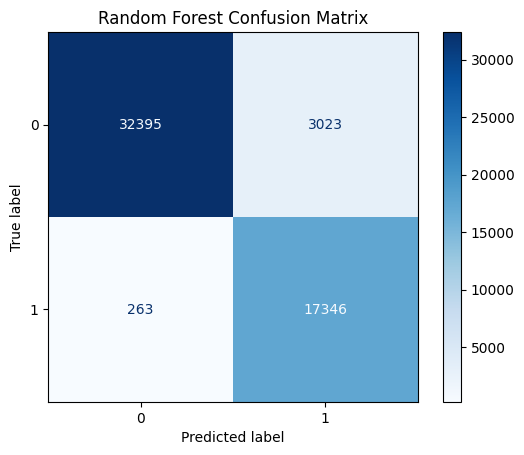

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_pred_rf)

# Print Metrics
print(f"Random Forest:\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}\nROC_AUC: {roc_auc:.2f}\n")


# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
)
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()

Random OverSampling

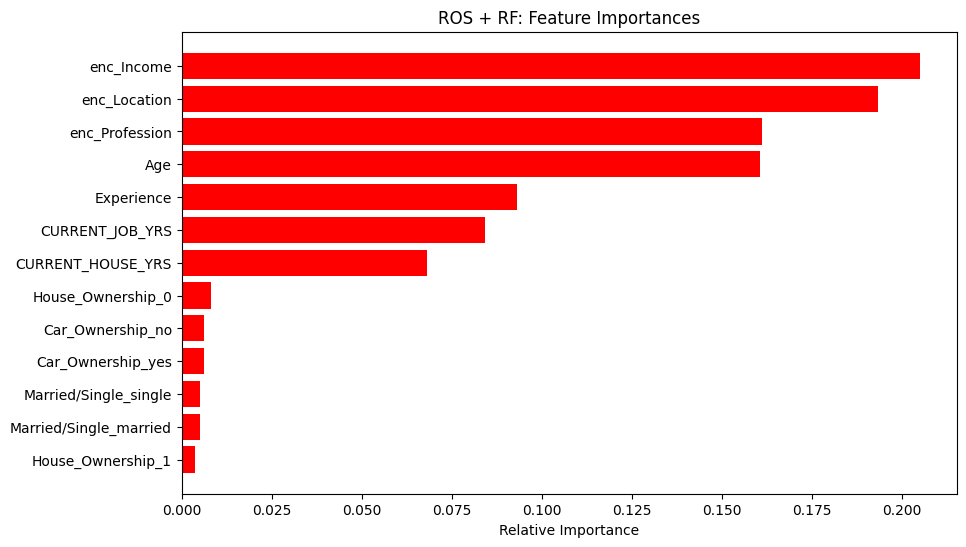

In [ ]:
ros_RF = RandomForestClassifier(random_state=42).fit(X_os, y_os)

importances = ros_RF.feature_importances_
features = X_os.columns
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('ROS + RF: Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Predicting using Test data with ROS + Random Forest Classifier

Accuracy: 0.94
Precision: 0.85
Recall: 0.98
F1-Score: 0.91
ROC_AUC: 0.95



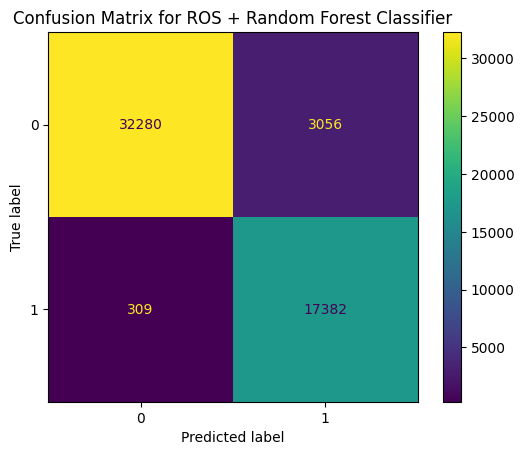

In [ ]:
X_os_if  = X_os.drop(['House_Ownership_0','House_Ownership_1','Car_Ownership_no','Car_Ownership_yes','Married/Single_single', 'Married/Single_married'],axis=1).copy()

X_train_if, X_test_if, y_train_if, y_test_if = train_test_split(X_os_if, y_os, test_size=0.2)
ros_RF = RandomForestClassifier(random_state=42).fit(X_train_if, y_train_if)

y_pred_ros_RF_if = ros_RF.predict(X_test_if)
accuracy = accuracy_score(y_test_if, y_pred_ros_RF_if)
precision = precision_score(y_test_if, y_pred_ros_RF_if)
recall = recall_score(y_test_if, y_pred_ros_RF_if)
f1 = f1_score(y_test_if, y_pred_ros_RF_if)
roc_auc = roc_auc_score(y_test_if, y_pred_ros_RF_if)
print('\nPredicting using Test data with ROS + Random Forest Classifier\n')
print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}\nROC_AUC: {roc_auc:.2f}\n")
cm = confusion_matrix(y_test_if, y_pred_ros_RF_if)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix for ROS + Random Forest Classifier')
plt.show()

### EBM

In [ ]:
import joblib
impo_ebm_model = joblib.load(r'/content/drive/MyDrive/SEM 4/EBM_Balanced.pkl')
show(impo_ebm_model.explain_global())

# Predict Test set and check accuracy

In [ ]:
print(test_data.columns)
print(test_data.shape)

Index(['Age', 'Experience', 'Married/Single_single', 'Married/Single_married',
       'House_Ownership_0', 'House_Ownership_1', 'Car_Ownership_no',
       'Car_Ownership_yes', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
       'Risk_Flag', 'enc_Profession', 'enc_Location', 'enc_Income'],
      dtype='object')
(50400, 14)



Predicting using Unseen Test data with ROS + Random Forest Classifier

Accuracy: 0.89
Precision: 0.55
Recall: 0.76
F1-Score: 0.64
ROC_AUC: 0.84



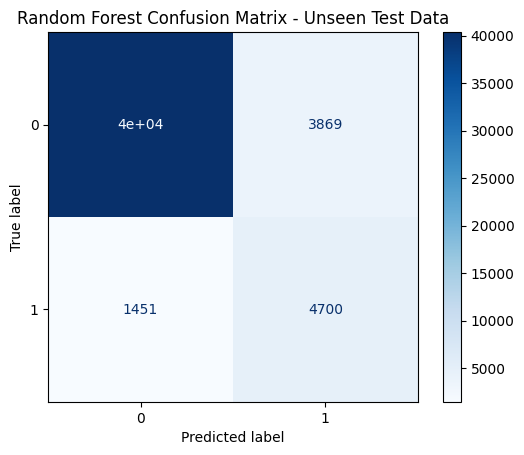

In [ ]:
# Prepare unseen test data - Unbalanced test data before OverSampling
X_unseen_if = test_data.drop(['House_Ownership_0', 'House_Ownership_1',
                          'Car_Ownership_no', 'Car_Ownership_yes',
                          'Married/Single_single', 'Married/Single_married','Risk_Flag'], axis=1).copy()

y_unseen_if = test_data['Risk_Flag']  # Ground truth labels for unseen test

# Predict
y_pred_unseen_if = ros_RF.predict(X_unseen_if)

# Metrics
accuracy = accuracy_score(y_unseen_if, y_pred_unseen_if)
precision = precision_score(y_unseen_if, y_pred_unseen_if)
recall = recall_score(y_unseen_if, y_pred_unseen_if)
f1 = f1_score(y_unseen_if, y_pred_unseen_if)
roc_auc = roc_auc_score(y_unseen_if, y_pred_unseen_if)

# Print Metrics
print('\nPredicting using Unseen Test data with ROS + Random Forest Classifier\n')
print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1-Score: {f1:.2f}\nROC_AUC: {roc_auc:.2f}\n")

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(
    ros_RF,
    X_unseen_if,
    y_unseen_if,
    cmap=plt.cm.Blues,
)
disp.ax_.set_title('Random Forest Confusion Matrix - Unseen Test Data')
plt.show()

### SHAP

In [ ]:
# Small sample from validation set
small_X_test_if = X_test_if.sample(200, random_state=42)

In [ ]:
# Initialize SHAP Explainer
explainer = shap.Explainer(ros_RF.predict, small_X_test_if)
shap_values = explainer(small_X_test_if)

ExactExplainer explainer: 201it [00:58,  3.09it/s]


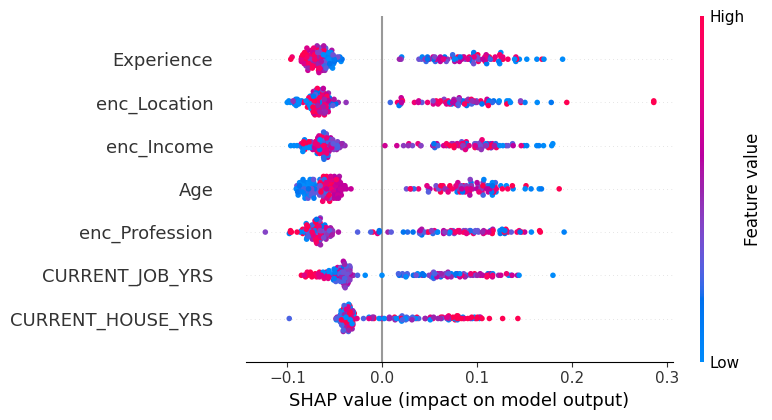

In [ ]:
# Summary plot
shap.summary_plot(shap_values.values, small_X_test_if)

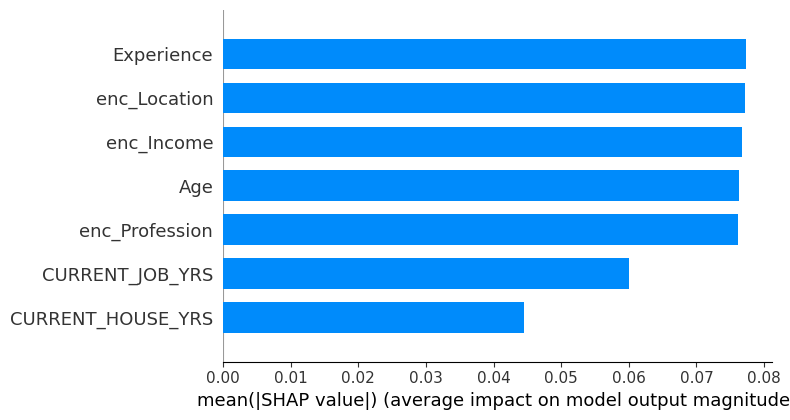

In [ ]:
shap.summary_plot(shap_values.values, small_X_test_if, plot_type="bar")

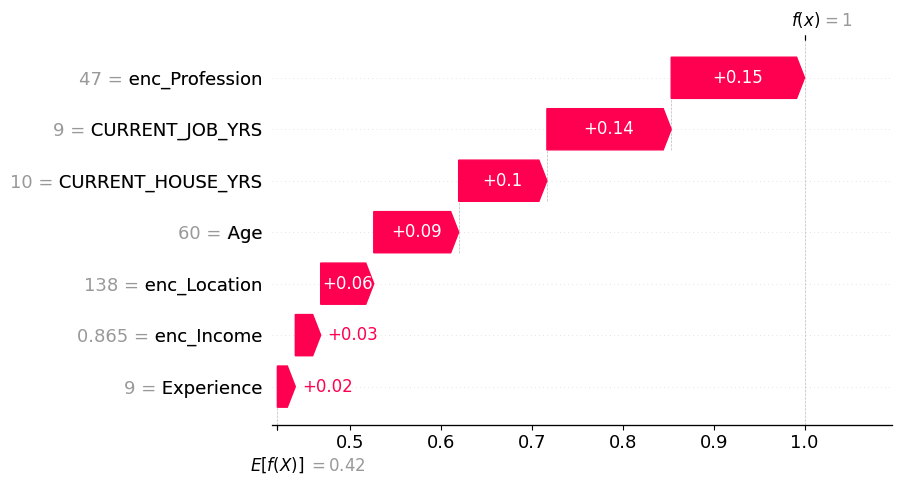

In [ ]:
#Pick a Sample for Detailed Explanations
sample_idx_pos = 24 # You can change this index

#SHAP Waterfall Plot (for one sample)
shap.plots.waterfall(shap_values[sample_idx_pos])

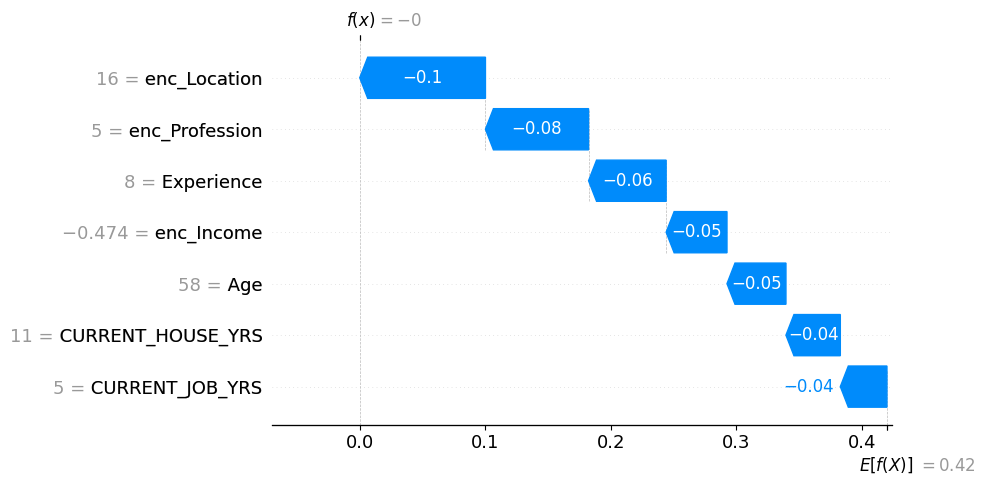

In [ ]:
#Pick a Sample for Detailed Explanations
sample_idx_neg = 65 # You can change this index

#SHAP Waterfall Plot (for one sample)
shap.plots.waterfall(shap_values[sample_idx_neg])

In [ ]:
#SHAP Force Plot (for one sample)
shap.initjs()
shap.plots.force(shap_values[sample_idx_pos])

In [ ]:
#SHAP Force Plot (for one sample)
shap.initjs()
shap.plots.force(shap_values[sample_idx_neg])

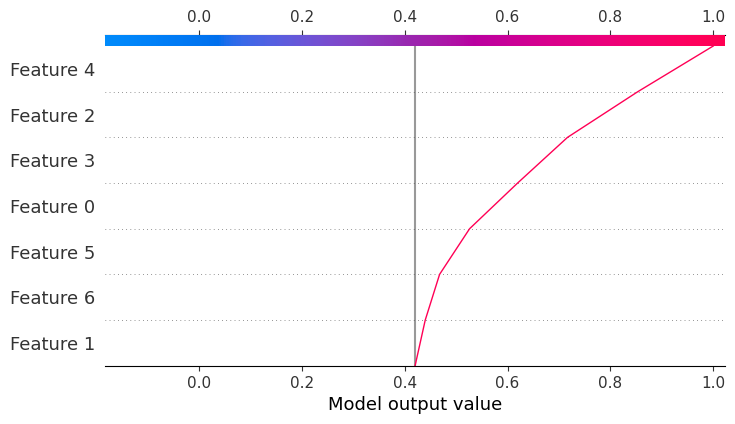

In [ ]:
# SHAP Decision Plot (for single sample)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_idx_pos]
)

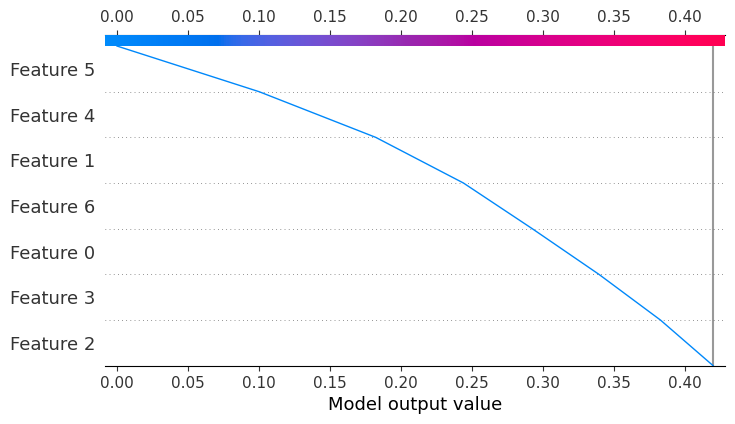

In [ ]:
# SHAP Decision Plot (for single sample)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_idx_neg]
)

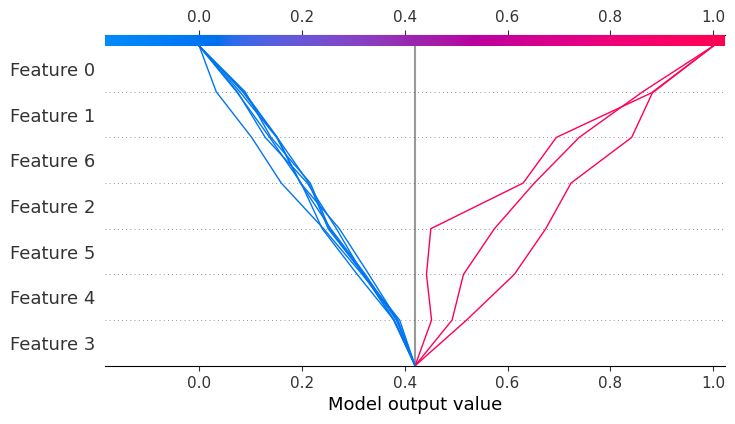

In [ ]:
#SHAP Decision Plot (for multiple samples)
sample_indices = np.random.choice(range(small_X_test_if.shape[0]), 10, replace=False)
shap.plots.decision(
    shap_values.base_values[0],
    shap_values.values[sample_indices]
)

### LIME

In [ ]:
# Create LIME Explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_if),
    feature_names=X_train_if.columns,
    class_names=['Not Risky', 'Risky'],
    mode='classification'
)

# Pick one sample from X_test_if
sample_idx_pos = 24 # You can change this index to explain different samples
sample_instance = np.array(X_test_if.iloc[sample_idx])

# Explain the selected instance
explanation = explainer_lime.explain_instance(
    data_row=sample_instance,
    predict_fn=ros_RF.predict_proba
)

# Show Explanation
explanation.show_in_notebook(show_table=True)

PDP Plots

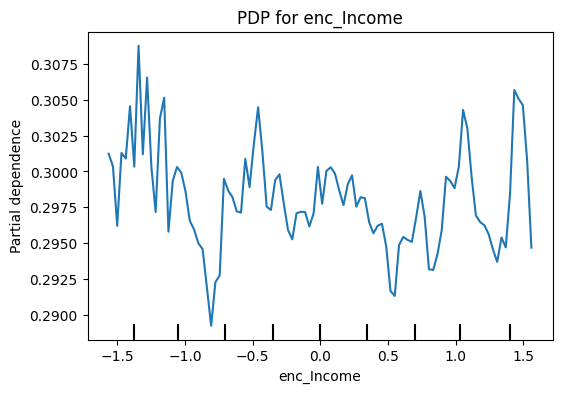

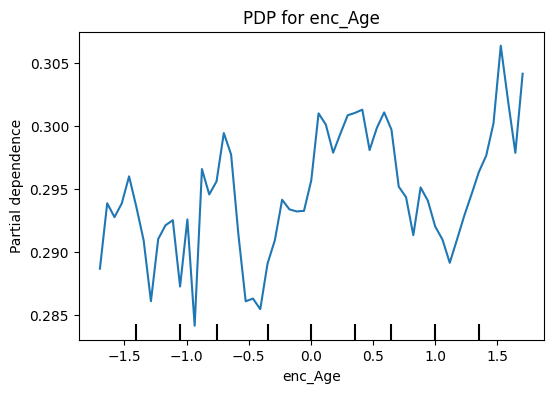

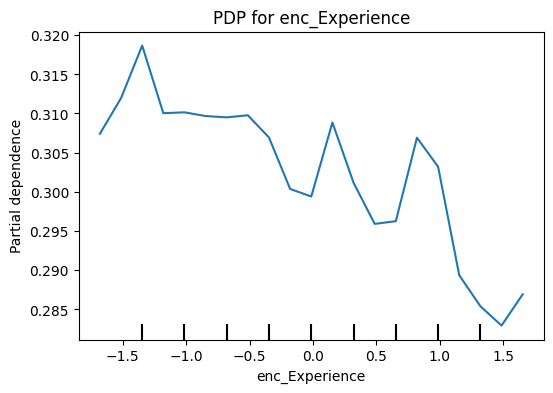

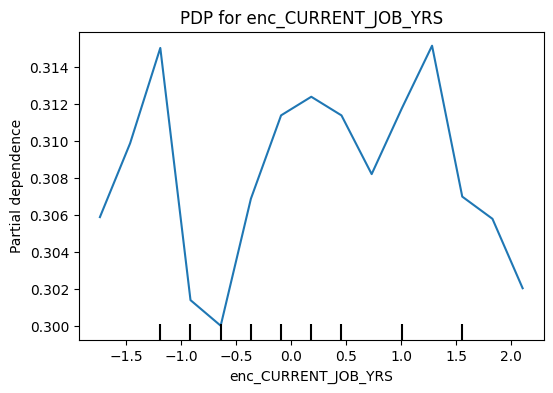

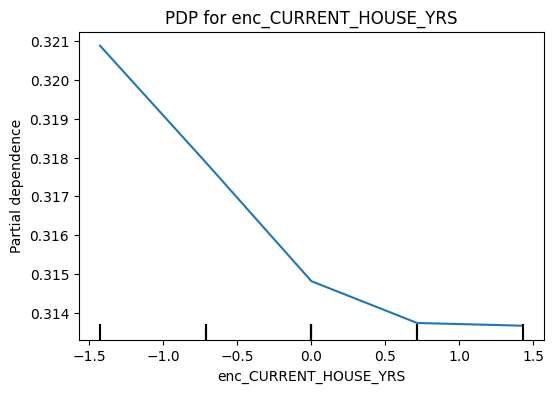

In [ ]:
# PDP PLOTS (using sklearn)
features_to_plot = ['enc_Income', 'enc_Age', 'enc_Experience', 'enc_CURRENT_JOB_YRS', 'enc_CURRENT_HOUSE_YRS']

for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    display = PartialDependenceDisplay.from_estimator(
        ros_RF,  X_test_if, [feature], ax=ax
    )
    plt.title(f'PDP for {feature}')
    plt.show()

ALE Plots

INFO:PyALE._ALE_generic:Continuous feature detected.


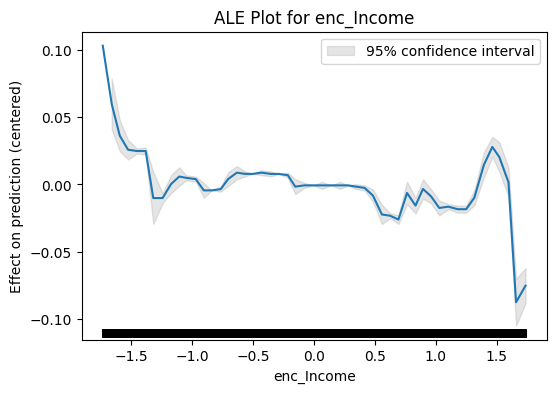

INFO:PyALE._ALE_generic:Discrete feature detected.


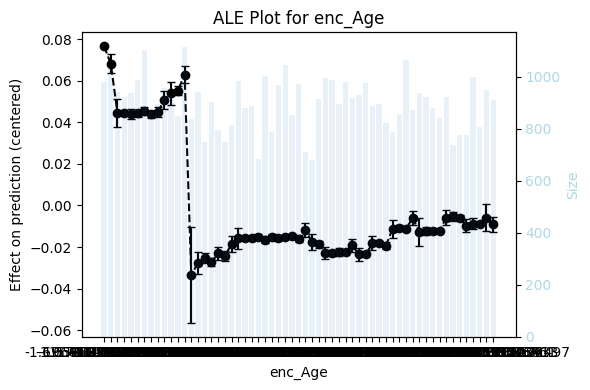

INFO:PyALE._ALE_generic:Discrete feature detected.


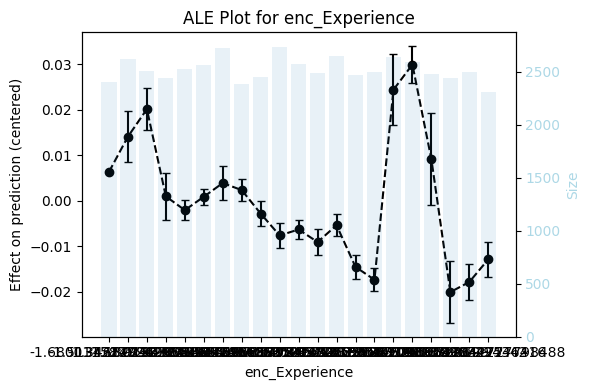

INFO:PyALE._ALE_generic:Discrete feature detected.


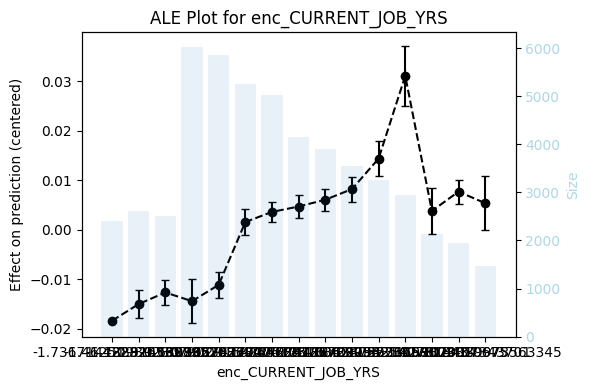

INFO:PyALE._ALE_generic:Discrete feature detected.


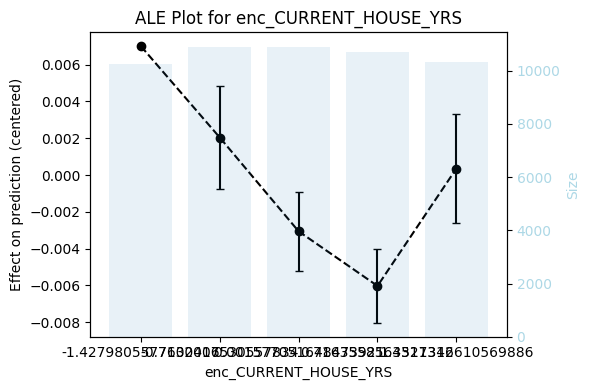

In [ ]:
# List of features to plot ALE for
features_to_plot = ['enc_Income', 'enc_Age', 'enc_Experience', 'enc_CURRENT_JOB_YRS', 'enc_CURRENT_HOUSE_YRS']

# Generate ALE plots one by one
for feature in features_to_plot:
    fig, ax = plt.subplots(figsize=(6, 4))
    ale_eff = ale(
        model=ros_RF,                      # your trained model
        X=X_test_if,                       # feature data (must match model)
        feature=[feature],                 # feature to plot
        include_CI=True,                    # optional: show confidence intervals
        grid_size=50,                       # optional: number of bins
        ax=ax,
        fig=fig
    )
    plt.title(f'ALE Plot for {feature}')
    plt.show()


### Anchors

In [ ]:
# Save ros_RF trained on X_os_if and y_os
joblib.dump({
    "model": ros_RF,
    "X": X_os_if,
    "y": y_os
}, "rf_balanced_data.pkl")

artifact = joblib.load("rf_balanced_data.joblib")

ros_RF = artifact["model"]
X_os_if = artifact["X"]
y_os = artifact["y"]


In [ ]:
#Define prediction function
predict_fn = lambda x: ros_RF.predict(x)

#Feature names
feature_names = X_os_if.columns.tolist()

#Initialize the Anchor explainer
anchor_explainer = AnchorTabular(predict_fn, feature_names)


In [ ]:
#Fit the explainer on your balanced data
anchor_explainer.fit(X_os_if.values, disc_perc=(10, 25, 50, 75, 90))


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (10, 25, 50, 75, 90)},
  'version': '0.9.6'}
)

In [ ]:
#Find an instance where prediction is 0
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx].values.reshape(1, -1)
    pred = ros_RF.predict(instance)[0]
    if pred == 0:
        instance_0_idx = idx
        break

# Explain
instance_0 = X_os_if.iloc[instance_0_idx].values.reshape(1, -1)
prediction_0 = ros_RF.predict(instance_0)[0]

print(f"\nAnchor Explanation for instance {instance_0_idx} (Prediction: {prediction_0}):")

anchor_explanation_0 = anchor_explainer.explain(instance_0, threshold=0.95)

print(f"Anchor: {anchor_explanation_0.anchor}")
print(f"Precision: {anchor_explanation_0.precision:.2f}")
print(f"Coverage: {anchor_explanation_0.coverage:.2f}")


Anchor Explanation for instance 0 (Prediction: 0):
Anchor: ['CURRENT_JOB_YRS > 9.00', '-0.88 < enc_Income <= -0.01', 'CURRENT_HOUSE_YRS > 12.00']
Precision: 0.98
Coverage: 0.02


In [ ]:
# Find an instance where prediction is 1
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx].values.reshape(1, -1)
    pred = ros_RF.predict(instance)[0]
    if pred == 1:
        instance_1_idx = idx
        break

# Explain
instance_1 = X_os_if.iloc[instance_1_idx].values.reshape(1, -1)
prediction_1 = ros_RF.predict(instance_1)[0]

print(f"\nAnchor Explanation for instance {instance_1_idx} (Prediction: {prediction_1}):")

anchor_explanation_1 = anchor_explainer.explain(instance_1, threshold=0.95)

print(f"Anchor: {anchor_explanation_1.anchor}")
print(f"Precision: {anchor_explanation_1.precision:.2f}")
print(f"Coverage: {anchor_explanation_1.coverage:.2f}")



Anchor Explanation for instance 4 (Prediction: 1):
Anchor: ['CURRENT_HOUSE_YRS <= 10.00', 'Age <= 26.00', '32.00 < enc_Location <= 79.00', 'enc_Profession <= 5.00', 'Experience <= 18.00', 'CURRENT_JOB_YRS <= 2.00', 'enc_Income <= 1.39']
Precision: 0.95
Coverage: 0.00


### Counterfactuals

In [ ]:
# Combine features and target into one DataFrame
data_df = X_os_if.copy()
data_df['target'] = y_os

# Identify continuous and categorical features
continuous_features = data_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_features.remove('target')  # Remove target from features
categorical_features = data_df.select_dtypes(include=['object', 'category']).columns.tolist()


In [ ]:
# Create DiCE data object
d = dice_ml.Data(dataframe=data_df,
                 continuous_features=continuous_features,
                 categorical_features=categorical_features,
                 outcome_name='target')

# Create DiCE model object
m = dice_ml.Model(model=ros_RF, backend='sklearn')


In [ ]:
# Initialize DiCE explainer
exp = dice_ml.Dice(d, m, method='random')

# Select the first instance where the prediction is 0
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx]
    pred = ros_RF.predict(instance.values.reshape(1, -1))[0]
    if pred == 0:
        query_instance = instance
        break

# Convert to DataFrame
query_instance_df = pd.DataFrame([query_instance])


In [ ]:
# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=3, desired_class="opposite")
# Visualize counterfactuals
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Query instance (original outcome : 0)


Age  Experience  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  enc_Profession  \
0  38.0        14.0             11.0               13.0            24.0   

   enc_Location  enc_Income  target  
0         113.0   -0.738381       0


Diverse Counterfactual set (new outcome: 1)


Age Experience CURRENT_JOB_YRS CURRENT_HOUSE_YRS enc_Profession  \
0  54.0          -               -                 -              -   
1     -          -             5.0                 -              -   
2     -          -               -              12.0              -   

  enc_Location  enc_Income target  
0         42.0  -1.3522064    1.0  
1        316.0           -    1.0  
2        316.0           -    1.0

In [ ]:
# Select the first instance where the prediction is 1
for idx in range(len(X_os_if)):
    instance = X_os_if.iloc[idx]
    pred = ros_RF.predict(instance.values.reshape(1, -1))[0]
    if pred == 1:
        query_instance = instance
        break

# Convert to DataFrame
query_instance_df = pd.DataFrame([query_instance])

# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance_df, total_CFs=3, desired_class="opposite")

# Visualize counterfactuals
dice_exp.visualize_as_dataframe(show_only_changes=True)


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

Query instance (original outcome : 1)


Age  Experience  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  enc_Profession  \
0  24.0         1.0              1.0               10.0             1.0   

   enc_Location  enc_Income  target  
0          79.0    0.338678       1


Diverse Counterfactual set (new outcome: 0)


Age Experience CURRENT_JOB_YRS CURRENT_HOUSE_YRS enc_Profession  \
0   -          -               -                 -              -   
1   -        5.0             5.0                 -              -   
2   -       17.0               -              14.0              -   

  enc_Location enc_Income target  
0            -  1.5897116    0.0  
1            -          -    0.0  
2            -          -    0.0

### Fairness Metrics

In [ ]:
features_to_test = ['Age', 'enc_Income', 'enc_Location', 'enc_Profession']

for feature in features_to_test:
    print(f"\nFairness Metrics Based on {feature}\n")

    temp_df = X_test_if.copy()
    temp_df['Risk_Flag'] = y_test_if.reset_index(drop=True)

    # Use median split
    threshold = temp_df[feature].median()
    temp_df['Protected_Attr'] = np.where(temp_df[feature] >= threshold, 1, 0)

    temp_df = temp_df.dropna().reset_index(drop=True)

    # Create AIF360 Dataset
    aif_data = BinaryLabelDataset(
        df=temp_df,
        label_names=['Risk_Flag'],
        protected_attribute_names=['Protected_Attr']
    )

    # Create Metric
    metric = BinaryLabelDatasetMetric(
        dataset=aif_data,
        privileged_groups=[{'Protected_Attr': 1}],
        unprivileged_groups=[{'Protected_Attr': 0}]
    )

    # Print Metrics
    print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
    print(f"Disparate Impact: {metric.disparate_impact():.4f}")
    print(f"Difference in Mean Outcomes: {metric.mean_difference():.4f}")



Fairness Metrics Based on Age

Statistical Parity Difference: -0.0014
Disparate Impact: 0.9958
Difference in Mean Outcomes: -0.0014

Fairness Metrics Based on enc_Income

Statistical Parity Difference: 0.0067
Disparate Impact: 1.0201
Difference in Mean Outcomes: 0.0067

Fairness Metrics Based on enc_Location

Statistical Parity Difference: -0.0087
Disparate Impact: 0.9746
Difference in Mean Outcomes: -0.0087

Fairness Metrics Based on enc_Profession

Statistical Parity Difference: 0.0042
Disparate Impact: 1.0126
Difference in Mean Outcomes: 0.0042
